# CS624 Final Project

## Read the data from  Parquet Files

In [0]:
#Pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType,DoubleType,DateType,TimestampType,LongType
from pyspark.sql.functions import mean, min, max, stddev, regexp_replace,trim
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, trim
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext,SparkConf

#Plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]
#Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import pandas as pd
import numpy as np 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [0]:
spark

In [0]:
class DataParquet:
    def __init__(self, app_name="DataParquet"):
        """
        Initializes a Spark session.

        Args:
        - app_name: Name of the Spark application.
        """
        conf = SparkConf()
        conf.set("spark.executor.memory", "20g")
        conf.set("spark.driver.memory", "10g")
        conf.set("spark.executor.cores", "4")
        conf.set("spark.default.parallelism", "200")
        conf.set("spark.sql.shuffle.partitions", "200")
        conf.set("spark.executor.extraJavaOptions", "-XX:+UseG4GC")
        conf.set("spark.dynamicAllocation.enabled", "true")
        conf.set("spark.shuffle.service.enabled", "true")
        conf.set("spark.memory.fraction", "0.7")
        conf.set("spark.memory.storageFraction", "0.5")
        self.spark = SparkSession.builder \
            .appName(app_name) \
            .config(conf=conf) \
            .getOrCreate()


    def read_parquet(self, file_path, header=True, infer_schema=True):
        """
        Reads a Parquet file into a DataFrame.

        Args:
        - file_path: Path to the Parquet file.
        - header: Whether the Parquet file has a header row.
        - infer_schema: Whether to infer the data types of columns.

        Returns:
        - DataFrame: The DataFrame containing the Parquet data.
        """
       
        return self.spark.read.parquet(file_path, header=header, inferschema=True)
    
    def ChangeDataType(self,clean_data):
        schema = StructType([
        StructField("Timestamp", LongType(), True),
        StructField("Open", DoubleType(), True),
        StructField("High", DoubleType(), True),
        StructField("Low", DoubleType(), True),
        StructField("Close", DoubleType(), True),
        StructField("Volume_(BTC)", DoubleType(), True),
        StructField("Volume_(Currency)", DoubleType(), True),
        StructField("Weighted_Price", DoubleType(), True),
        StructField("Timestamp_new", TimestampType(), True),
        ])

        new_data = clean_data.select(
        [clean_data[col_name].cast(schema[col_name].dataType).alias(col_name) for col_name in clean_data.columns])
        return new_data


    def stop(self):
        """
        Stops the Spark session.
        """
        self.spark.stop()



In [0]:
dp = DataParquet(app_name="DataParquet")
URL="/FileStore/tables/parquet_data/converted_data_hist.parquet"
converted_data_hist = dp.read_parquet(URL)
converted_data_hist=dp.ChangeDataType(converted_data_hist)
converted_data_hist.persist()

DataFrame[Timestamp: bigint, Open: double, High: double, Low: double, Close: double, Volume_(BTC): double, Volume_(Currency): double, Weighted_Price: double, Timestamp_new: timestamp]

## Summary of Historical DataSet

In [0]:
print(f"The count of dataframe before removing NANs and duplicate {converted_data_hist.count()}")

The count of dataframe before removing NANs and duplicate 4857377


In [0]:
converted_data_hist_updated = converted_data_hist.na.drop("any")
data_unique=converted_data_hist_updated.dropDuplicates()
data_unique.describe().toPandas().transpose()    

0                     1  ...           3               4
summary              count                  mean  ...         min             max
Timestamp          3613769  1.4978979520670745E9  ...  1325317920      1617148800
Open               3613769     6009.023680136135  ...         3.8        61763.56
High               3613769     6013.357081608371  ...         3.8        61781.83
Low                3613769     6004.488003504777  ...         1.5        61673.55
Close              3613769     6009.013545014104  ...         1.5         61781.8
Volume_(BTC)       3613769     9.323249222687718  ...         0.0    5853.8521659
Volume_(Currency)  3613769     41762.84239707957  ...         0.0  1.3900672407E7
Weighted_Price     3613769     6008.934800287565  ...         3.8    61716.205341

[9 rows x 5 columns]

In [0]:
class RenameAndRerranging:

    def Renamed(self,data_unique):
        data_unique=data_unique.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")
        return data_unique
    
    def DateTimeSplit(self,data_unique):
        datatime_dataframe= data_unique
        splitDF = datatime_dataframe.withColumn("date",split(col("Timestamp_new")," ").getItem(0))
        splitDF = splitDF.withColumn("time",split(col("Timestamp_new")," ").getItem(1))
        splitDFHour = splitDF.withColumn("hour",split(col("time"),":").getItem(0))
        splitDFHour= splitDFHour.withColumn("date",splitDFHour["date"].cast(DateType())).withColumn("hour",splitDFHour["hour"].cast(DoubleType())).withColumn("Timestamp_new",splitDFHour["Timestamp_new"].cast(DateType()))
        splitDFHour=splitDFHour.withColumn('day_of_week',dayofweek(splitDFHour.date))
        splitDFWithYear = splitDFHour.withColumn("year",split(col("date"),"-").getItem(0))
        return splitDFWithYear


ra =RenameAndRerranging()

In [0]:
data_unique = ra.Renamed(data_unique)
data_unique.persist()

DataFrame[Timestamp: bigint, Open: double, High: double, Low: double, Close: double, VolBTC: double, VolCurrency: double, Weighted_Price: double, Timestamp_new: timestamp]

In [0]:
splitDFWithYear = ra.DateTimeSplit(data_unique)
splitDFWithYear.persist()
splitDFWithYear.display()

Timestamp Open High Low Close VolBTC VolCurrency Weighted_Price Timestamp_new date time hour day_of_week year 1496439840 2436.51 2437.01 2436.51 2437.01 1.64354576 4005.1168627 2436.8757842 2017-06-02 2017-06-02 21:44:00 21.0 6 2017 1496464380 2471.08 2474.09 2467.21 2467.21 17.57202134 43460.461992 2473.2761901 2017-06-03 2017-06-03 04:33:00 4.0 7 2017 1496477280 2489.37 2490.0 2488.37 2490.0 1.57507919 3921.0104985 2489.4053095 2017-06-03 2017-06-03 08:08:00 8.0 7 2017 1496496600 2518.8 2521.22 2517.34 2521.21 1.05398395 2655.1087929 2519.1169115 2017-06-03 2017-06-03 13:30:00 13.0 7 2017 1496498280 2521.27 2521.27 2515.45 2515.45 10.26463587 25851.402806 2518.4919498 2017-06-03 2017-06-03 13:58:00 13.0 7 2017 1496500260 2537.87 2538.0 2537.87 2537.96 1.18828669 3015.860772 2537.9908715 2017-06-03 2017-06-03 14:31:00 14.0 7 2017 1496517420 2564.88 2564.91 2564.86 2564.91 9.84386288 25248.519826 2564.899586 2017-06-03 2017-06-03 19:17:00 19.0 7 2017 1496539800 2517.32 2518.9 2516.96 2518.88 7.26246844 18288.965668 2518.2850457 2017-06-04 2017-06-04 01:30:00 1.0 1 2017 1496574240 2539.31 2542.3 2539.3 2542.3 20.8280432 52922.669162 2540.9333298 2017-06-04 2017-06-04 11:04:00 11.0 1 2017 1496583780 2526.01 2526.01 2524.96 2524.96 3.76385622 9505.5706741 2525.4871915 2017-06-04 2017-06-04 13:43:00 13.0 1 2017 1496584080 2524.29 2524.29 2524.29 2524.29 1.749 4414.98321 2524.29 2017-06-04 2017-06-04 13:48:00 13.0 1 2017 1496587200 2531.1 2531.1 2531.09 2531.09 0.45715301 1157.0990772 2531.0980173 2017-06-04 2017-06-04 14:40:00 14.0 1 2017 1496609100 2500.46 2505.09 2500.46 2505.09 42.50460457 106469.18993 2504.8860236 2017-06-04 2017-06-04 20:45:00 20.0 1 2017 1496613900 2508.69 2508.69 2508.69 2508.69 2.0 5017.38 2508.69 2017-06-04 2017-06-04 22:05:00 22.0 1 2017 1496631240 2558.15 2558.15 2558.15 2558.15 0.00944952 24.173289588 2558.15 2017-06-05 2017-06-05 02:54:00 2.0 2 2017 1496635140 2583.67 2583.67 2583.67 2583.67 0.05 129.1835 2583.67 2017-06-05 2017-06-05 03:59:00 3.0 2 2017 1496649660 2575.25 2578.0 2573.52 2575.3 12.7118096 32743.557455 2575.8376254 2017-06-05 2017-06-05 08:01:00 8.0 2 2017 1496656680 2577.46 2578.12 2573.8 2573.8 6.6229556 17072.352889 2577.7543925 2017-06-05 2017-06-05 09:58:00 9.0 2 2017 1496664480 2590.0 2590.0 2581.98 2581.98 7.16511566 18535.624779 2586.9261095 2017-06-05 2017-06-05 12:08:00 12.0 2 2017 1496676840 2618.4 2624.99 2617.26 2624.0 10.23470564 26800.514245 2618.5916027 2017-06-05 2017-06-05 15:34:00 15.0 2 2017 1496680920 2618.7 2618.7 2612.0 2612.08 0.79457656 2078.5879553 2615.9693854 2017-06-05 2017-06-05 16:42:00 16.0 2 2017 1496685660 2618.2 2618.2 2615.02 2615.02 15.53652637 40631.862381 2615.2475407 2017-06-05 2017-06-05 18:01:00 18.0 2 2017 1496692740 2633.49 2634.99 2633.46 2634.99 6.26658564 16504.422422 2633.7184824 2017-06-05 2017-06-05 19:59:00 19.0 2 2017 1496704260 2679.95 2680.0 2678.0 2680.0 22.89354282 61354.014987 2679.9703073 2017-06-05 2017-06-05 23:11:00 23.0 2 2017 1496705940 2679.0 2679.0 2675.53 2675.53 8.014163 21469.893507 2678.9938646 2017-06-05 2017-06-05 23:39:00 23.0 2 2017 1496706840 2687.97 2689.93 2687.97 2689.93 5.68206508 15274.125375 2688.1292557 2017-06-05 2017-06-05 23:54:00 23.0 2 2017 1496712540 2731.27 2733.33 2731.18 2733.15 30.09370761 82195.210086 2731.3088554 2017-06-06 2017-06-06 01:29:00 1.0 3 2017 1496713440 2735.7 2737.98 2735.68 2735.68 3.64387622 9969.6699534 2736.0067553 2017-06-06 2017-06-06 01:44:00 1.0 3 2017 1496719560 2849.89 2851.49 2846.24 2846.24 10.87639048 30983.552802 2848.6980914 2017-06-06 2017-06-06 03:26:00 3.0 3 2017 1496724300 2846.97 2848.63 2843.02 2843.02 1.54365442 4396.4405641 2848.0730578 2017-06-06 2017-06-06 04:45:00 4.0 3 2017 1496729400 2839.99 2840.0 2836.8 2839.97 0.13690248 388.74417204 2839.5699774 2017-06-06 2017-06-06 06:10:00 6.0 3 2017 1496746740 2856.89 2859.69 2856.89 2859.69 0.68026496 1943.8925211 2857.5520355 2017-06-06 2017-06-06 10:59:00 10.0 3 2017 1496757600 2920.99 2920.99 2917.56 2919.7 0

In [0]:
splitDFWithYear.write.mode("overwrite").parquet("/FileStore/tables/parquet_data/splitDFWithYear.parquet", compression="snappy")

In [0]:
%fs ls /FileStore/tables/parquet_data/splitDFWithYear.parquet

path name size modificationTime dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/_committed_194472637999882623 _committed_194472637999882623 39823 1713147636000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/_committed_4560437261763541986 _committed_4560437261763541986 40200 1713214111000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/_committed_5126268284702871291 _committed_5126268284702871291 40134 1713235255000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/_committed_6211615641895843762 _committed_6211615641895843762 39823 1713209458000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/_committed_7733487696614056968 _committed_7733487696614056968 39968 1713597276000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/_committed_vacuum2913145035742733257 _committed_vacuum2913145035742733257 194 1713597280000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/_started_7733487696614056968 _started_7733487696614056968 0 1713597216000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/part-00000-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-513-1-c000.snappy.parquet part-00000-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-513-1-c000.snappy.parquet 980768 1713597229000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/part-00001-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-649-1-c000.snappy.parquet part-00001-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-649-1-c000.snappy.parquet 967874 1713597268000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/part-00002-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-628-1-c000.snappy.parquet part-00002-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-628-1-c000.snappy.parquet 976628 1713597263000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/part-00003-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-514-1-c000.snappy.parquet part-00003-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-514-1-c000.snappy.parquet 971145 1713597229000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/part-00004-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-650-1-c000.snappy.parquet part-00004-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-650-1-c000.snappy.parquet 970265 1713597269000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/part-00005-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-515-1-c000.snappy.parquet part-00005-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-515-1-c000.snappy.parquet 981402 1713597229000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/part-00006-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-516-1-c000.snappy.parquet part-00006-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-516-1-c000.snappy.parquet 967585 1713597230000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/part-00007-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-517-1-c000.snappy.parquet part-00007-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-517-1-c000.snappy.parquet 971865 1713597230000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/part-00008-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-482-1-c000.snappy.parquet part-00008-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-482-1-c000.snappy.parquet 973596 1713597218000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/part-00009-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-518-1-c000.snappy.parquet part-00009-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-518-1-c000.snappy.parquet 977855 1713597230000 dbfs:/FileStore/tables/parquet_data/splitDFWithYear.parquet/part-00010-tid-7733487696614056968-8db25125-75b8-4c84-85d7-3eb71e56e9f9-606-1-c000.snappy.parquet part-00010-tid-7733487696614056968-8db25125-75

# Exploratory Data Analysis

### Price Trend by year

In [0]:
class Plot:

    def PlotLine(self,splitDFWithYear_pandas):
        
        # Assuming splitDFWithYear_pandas is already loaded and formatted correctly:
        splitDFWithYear_pandas['Timestamp_new'] = pd.to_datetime(splitDFWithYear_pandas['Timestamp_new'])
        splitDFWithYear_pandas['VolCurrency'] = splitDFWithYear_pandas['VolCurrency'].astype(float)

        # Create a line plot
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=splitDFWithYear_pandas, x='Timestamp_new', y='VolCurrency')

        # Set plot title and labels
        plt.title('Historical Bitcoin Volume (USD) (2012-2021)')
        plt.xlabel('Date')
        plt.ylabel('Volume in USD')

        # Define the date format for the x-axis
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gcf().autofmt_xdate()  # Rotation

    def PlotScatter(self,splitDFWithYear_pandas):
        # Create a scatter plot using Seaborn
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=splitDFWithYear_pandas, x='Weighted_Price', y='VolBTC', color='#FFBAD2')

        # Set plot title and labels
        plt.title('BTC Volume vs. USD')
        plt.xlabel('Weighted Price (USD)')
        plt.ylabel('Volume (BTC)')

        # Adjusting layout
        plt.tight_layout()
        plt.show()


    def DoublePlot(self,x, title,c):
        fig, ax = plt.subplots(2,1,figsize=(25,10),sharex=True)
        sns.distplot(x, ax=ax[0],color=c)
        ax[0].set(xlabel=None)
        ax[0].set_title('Histogram + KDE')
        sns.boxplot(x, ax=ax[1],color=c,orient="h")
        ax[1].set(xlabel=None)
        ax[1].set_title('Boxplot')
        plt.tight_layout(pad=3.0)
        plt.show()
    

    def Corr(self,data_df):
        plt.figure(figsize=(8,8))
        corr=data_df[data_df.columns[1:]].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(data_df[data_df.columns[1:]].corr(), mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5,annot=True)
        plt.show()

    
    def MovingAvgs(self,data_df):

        import matplotlib.pyplot as plt
        import seaborn as snsfig
        # Create subplots
        fig, ax = plt.subplots(2, 2, figsize=(15, 15))

        # Plot histograms on each subplot
        sns.histplot(data_df["Open"], ax=ax[0][0])
        sns.histplot(data_df["Close"], ax=ax[0][1])
        sns.histplot(data_df["High"], ax=ax[1][0])
        sns.histplot(data_df["Low"], ax=ax[1][1])

        # Set titles for each subplot
        ax[0][0].set_title('Open Prices')
        ax[0][1].set_title('Close Prices')
        ax[1][0].set_title('High Prices')
        ax[1][1].set_title('Low Prices')

        # Show plot
        plt.show()


plts = Plot()

## Reduce memory of pandas dataframe

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

## Convert Pyspark Dataframe to Pandas for Visualizations

In [0]:
splitDFWithYear_pandas=splitDFWithYear.toPandas()

In [0]:
splitDFWithYear_pandas=reduce_mem_usage(splitDFWithYear_pandas)
splitDFWithYear_pandas.head()

Memory usage after optimization is: 189.55 MB
Decreased by 49.1%


Timestamp    Open    High     Low  ...      time  hour  day_of_week  year
0  1496439840  2436.0  2438.0  2436.0  ...  21:44:00  21.0            6  2017
1  1496464380  2472.0  2474.0  2468.0  ...  04:33:00   4.0            7  2017
2  1496477280  2490.0  2490.0  2488.0  ...  08:08:00   8.0            7  2017
3  1496496600  2518.0  2522.0  2518.0  ...  13:30:00  13.0            7  2017
4  1496498280  2522.0  2522.0  2516.0  ...  13:58:00  13.0            7  2017

[5 rows x 14 columns]

## Bitcoin Historical Price Trend

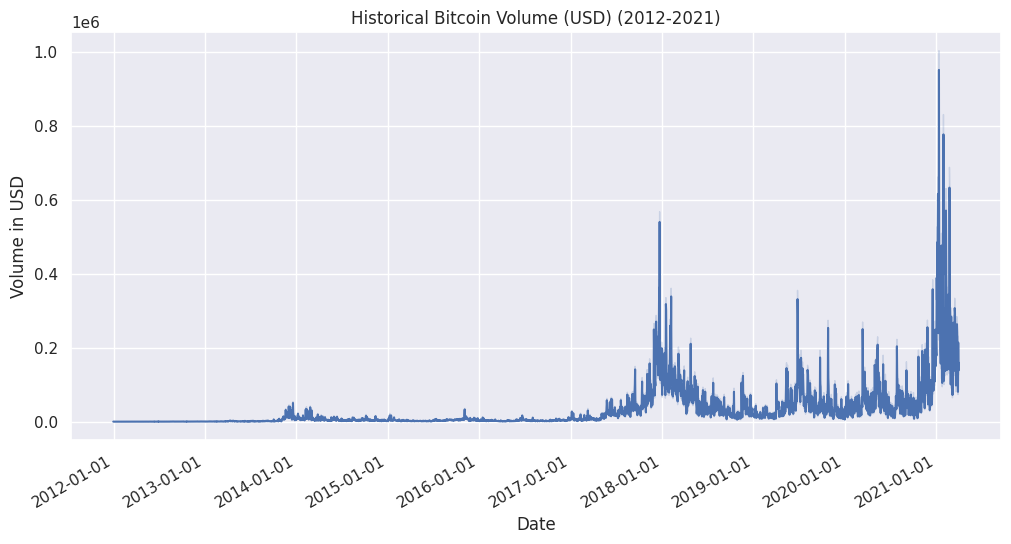

In [0]:
plts.PlotLine(splitDFWithYear_pandas)

## Scatter plot for Bitcoin Volume Vs USD

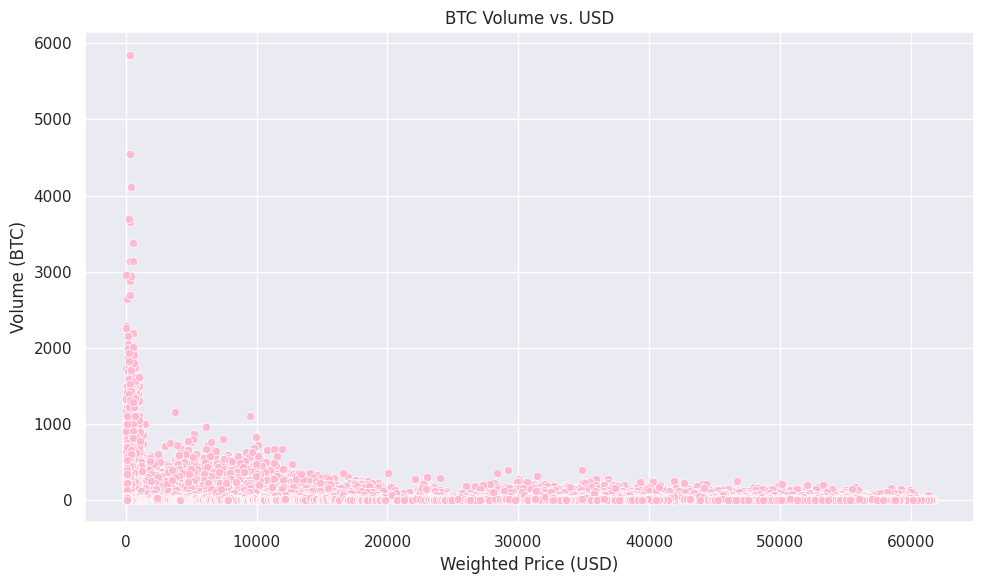

In [0]:
plts.PlotScatter(splitDFWithYear_pandas)

## Histogram and Box plot for Open,Close,High and Low

/root/.ipykernel/2159/command-651323311601319-48332007:40: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




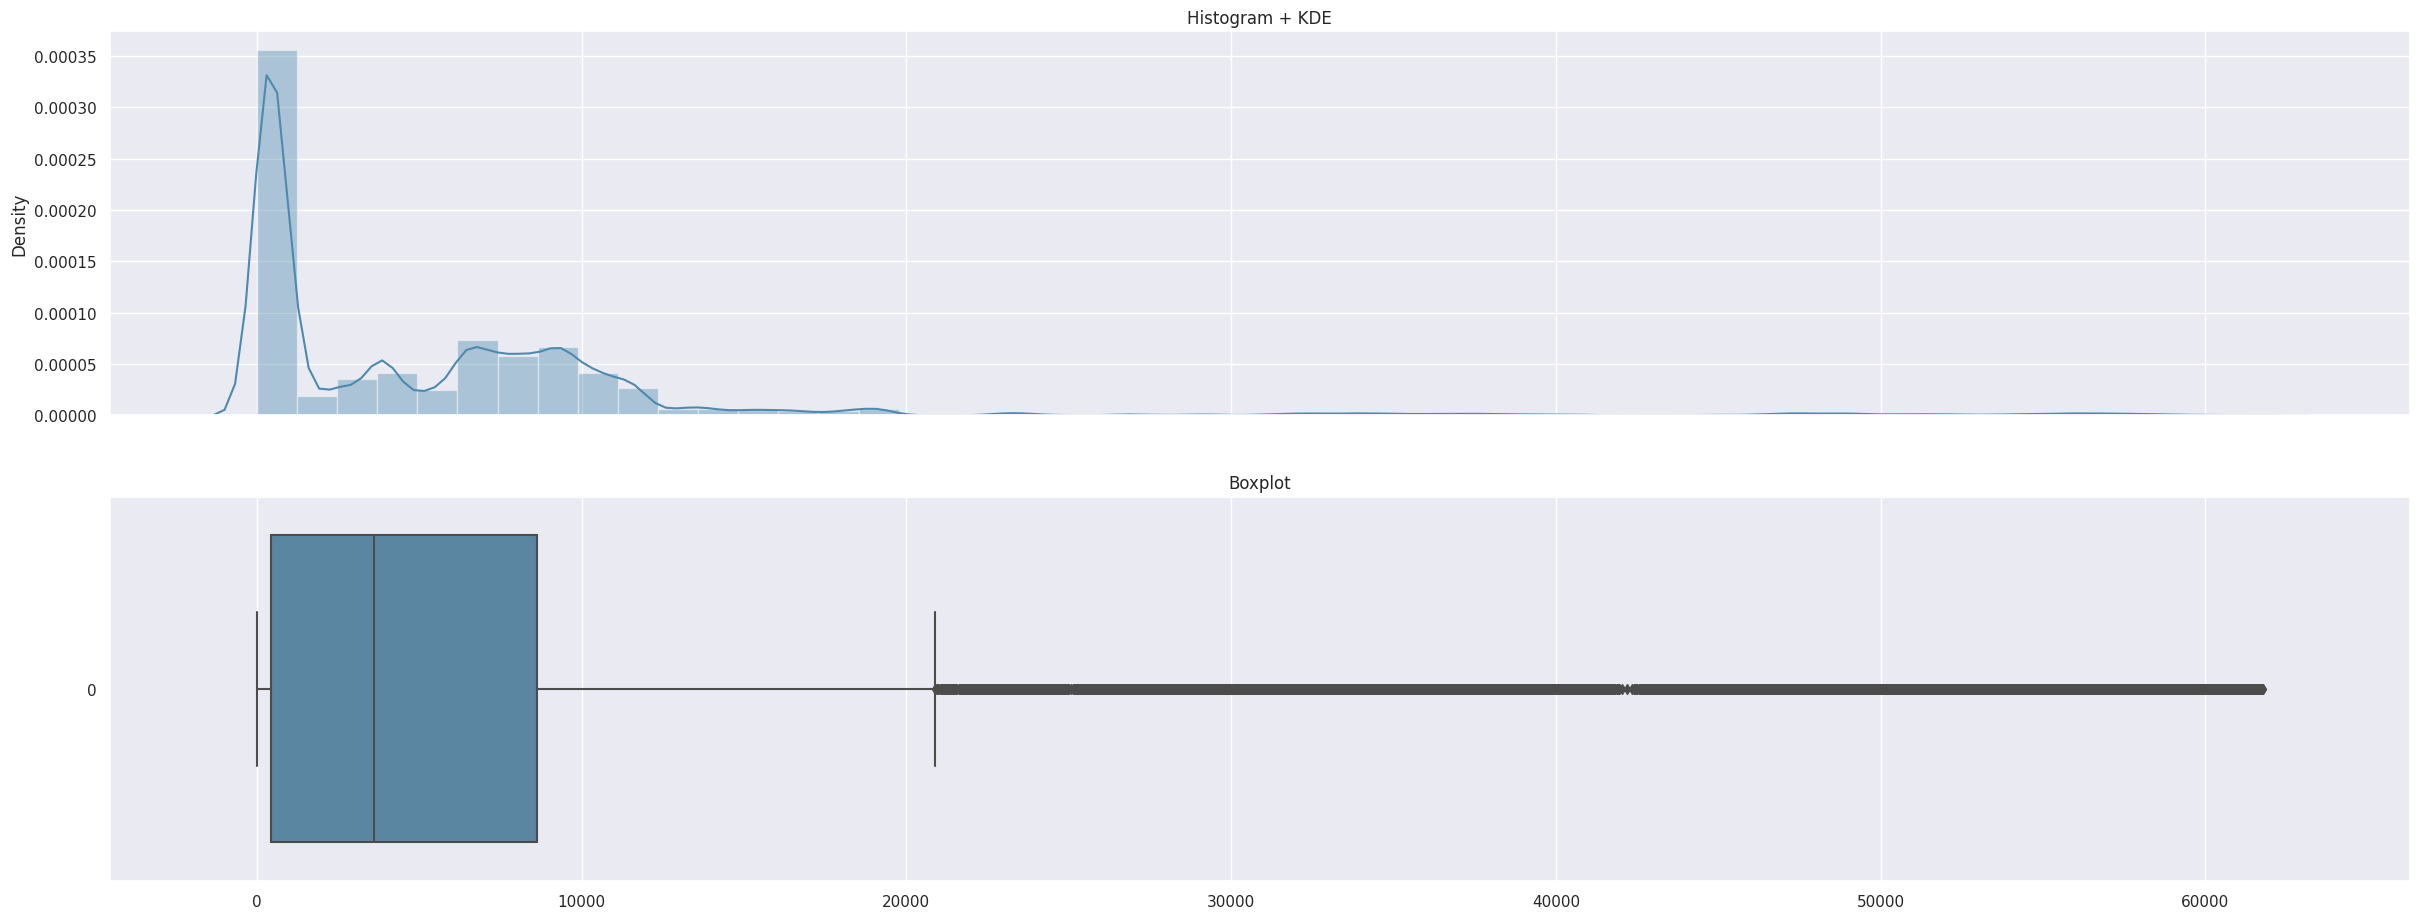

In [0]:
splitDFWithYear_pandas = splitDFWithYear_pandas.sort_values(by='Timestamp_new')
plts.DoublePlot(splitDFWithYear_pandas['Open'].tolist(),'Distribution of Opening price',custom_colors[0])

/root/.ipykernel/2159/command-651323311601319-48332007:40: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




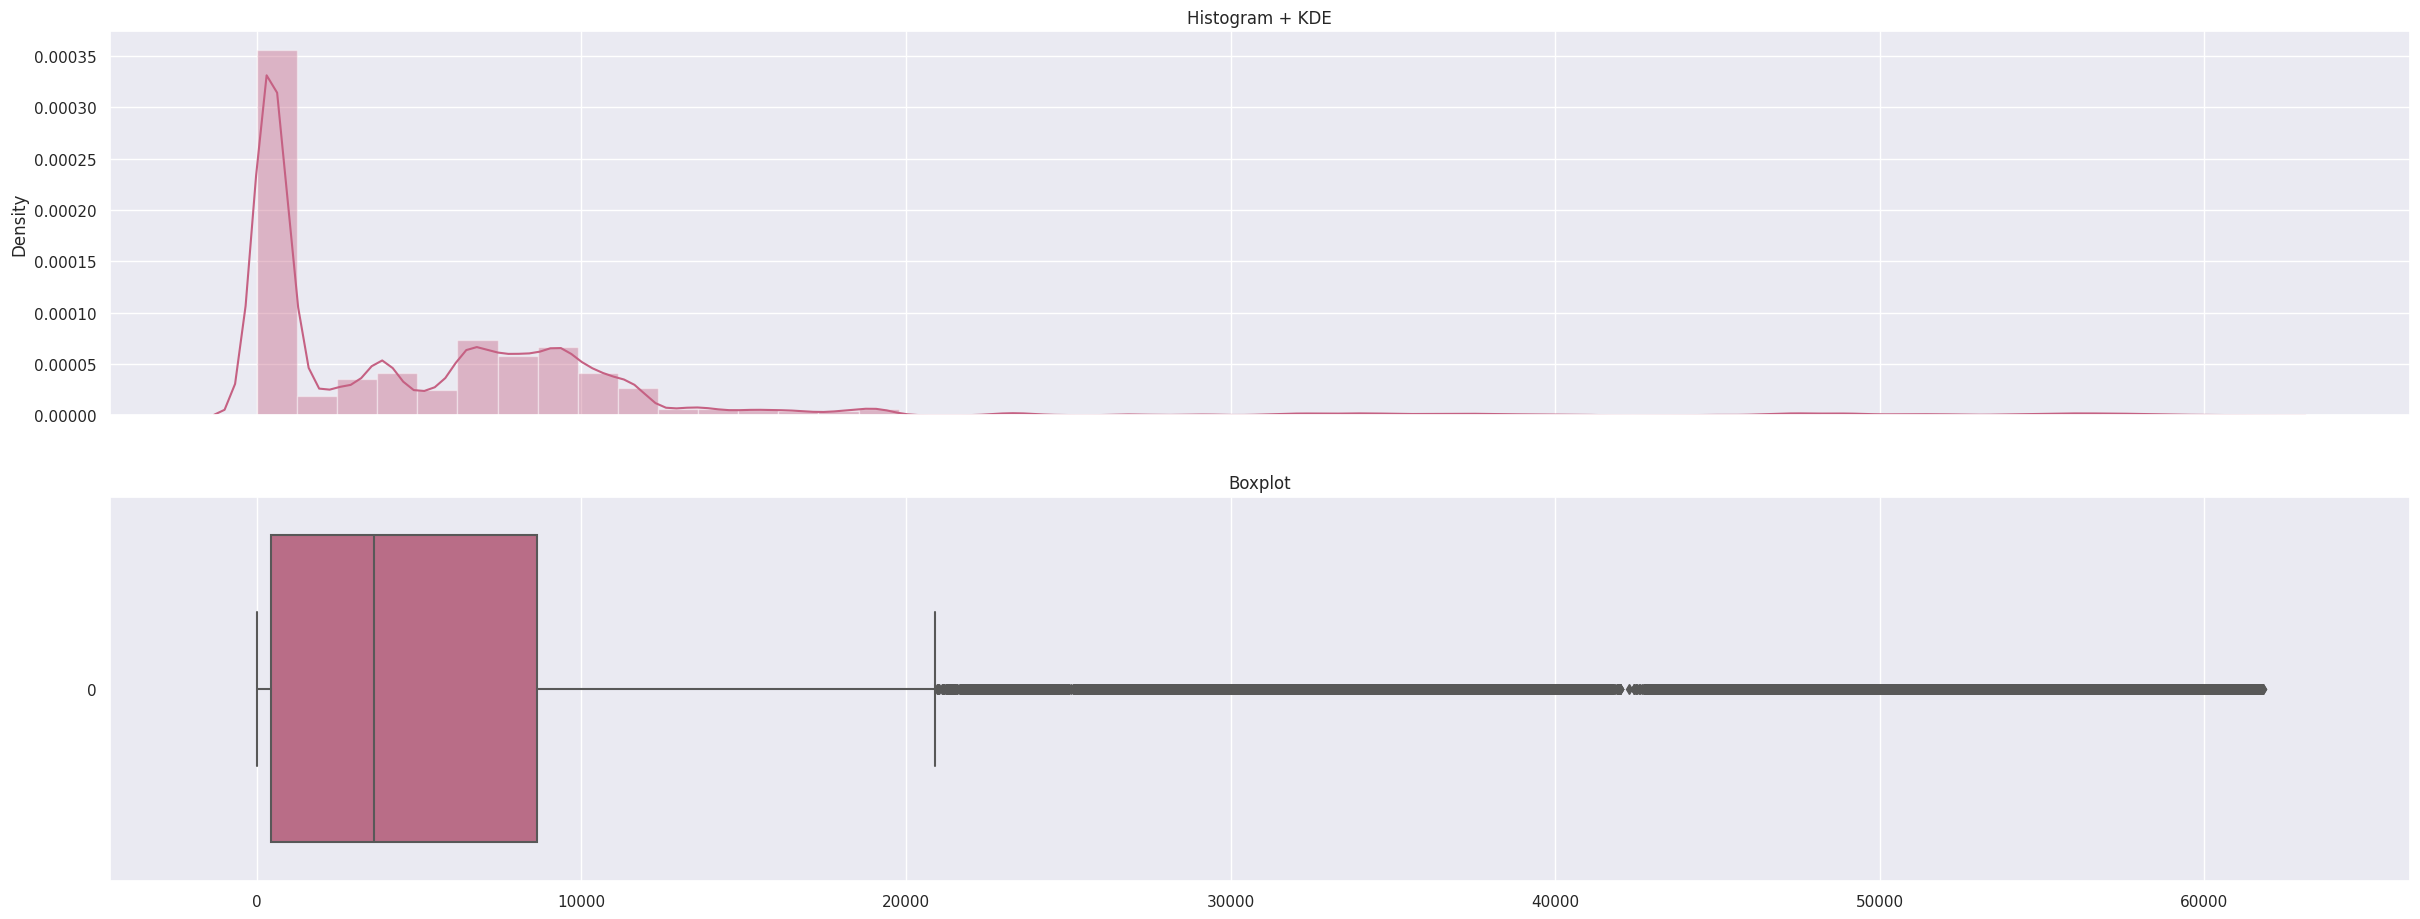

In [0]:
plts.DoublePlot(splitDFWithYear_pandas['High'].tolist(),'Distribution of Opening price',custom_colors[1])

/root/.ipykernel/2159/command-651323311601319-48332007:40: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




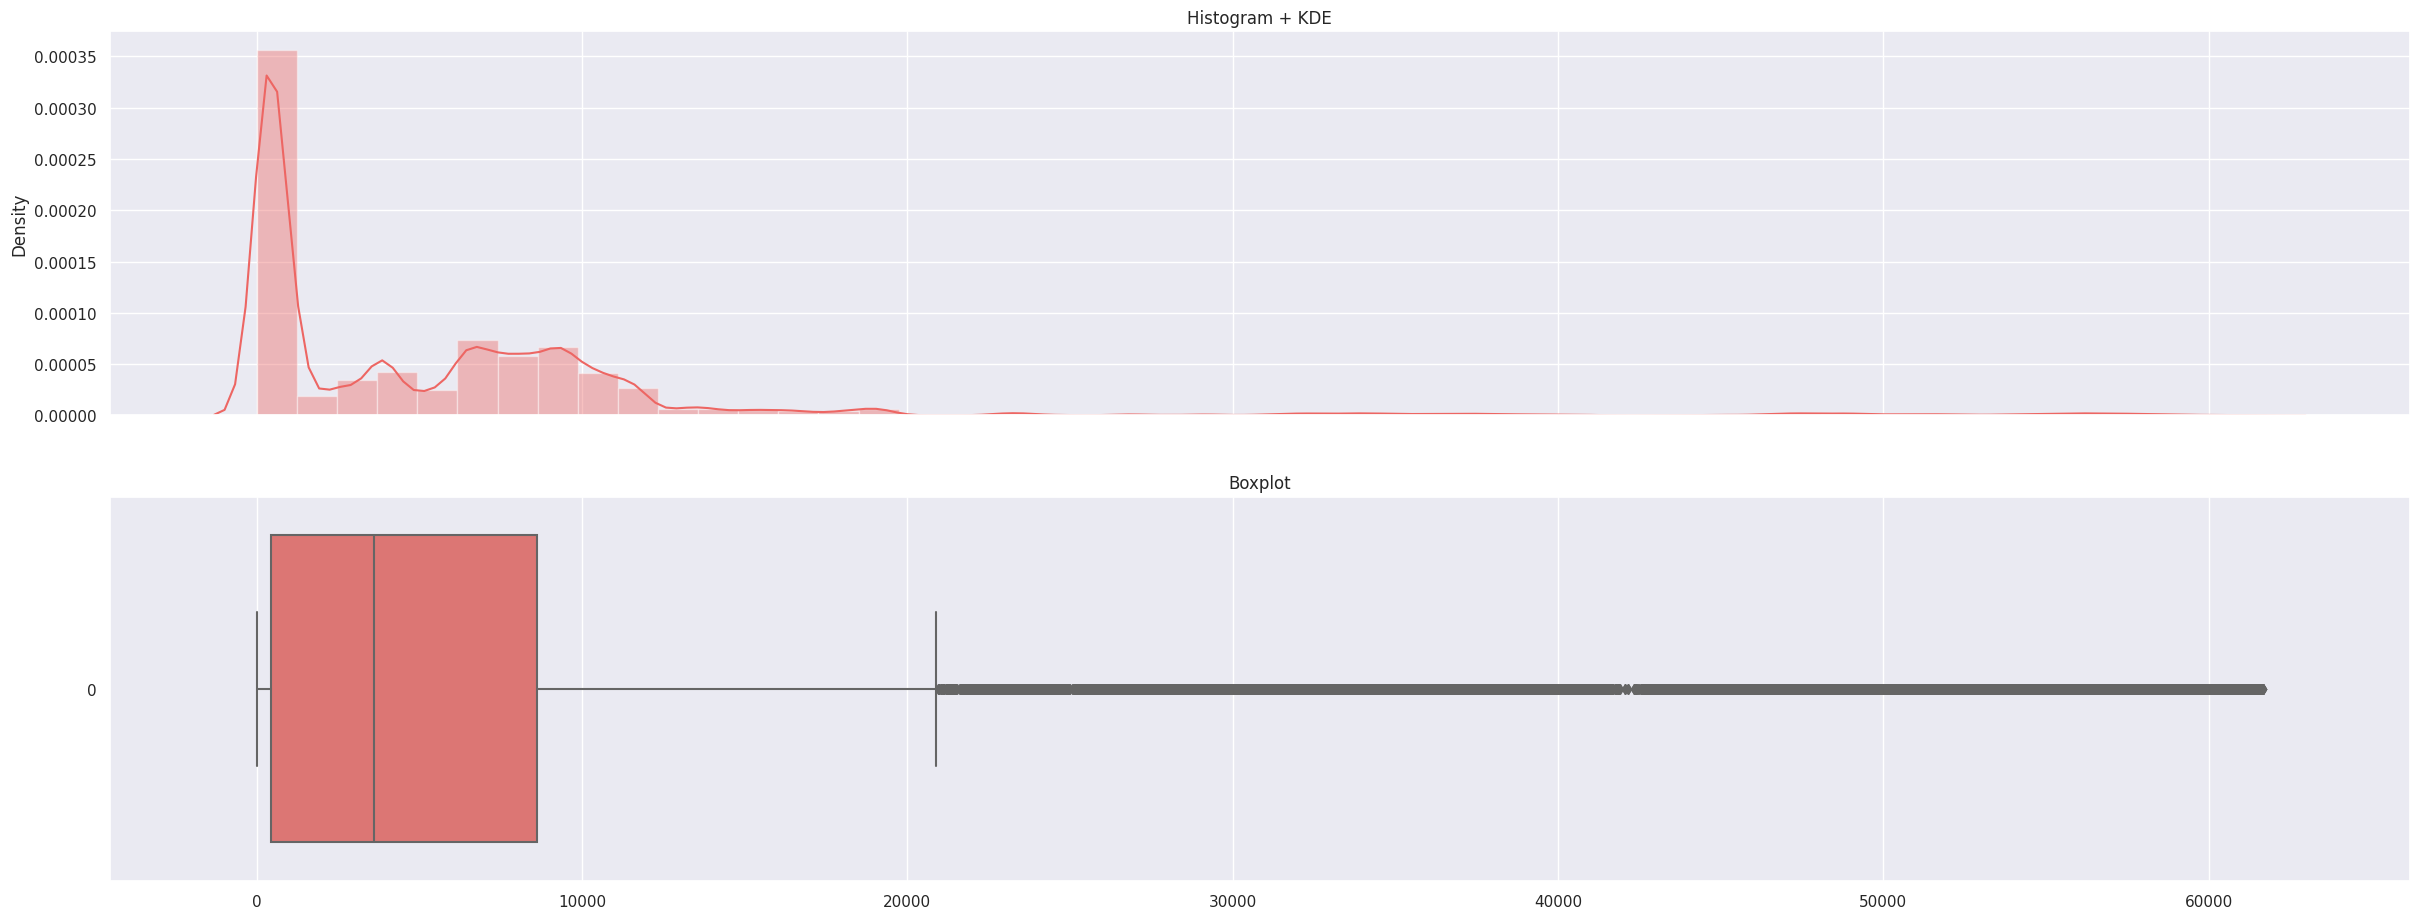

In [0]:
plts.DoublePlot(splitDFWithYear_pandas['Low'].tolist(),'Distribution of Opening price',custom_colors[2])

/root/.ipykernel/2159/command-651323311601319-48332007:40: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




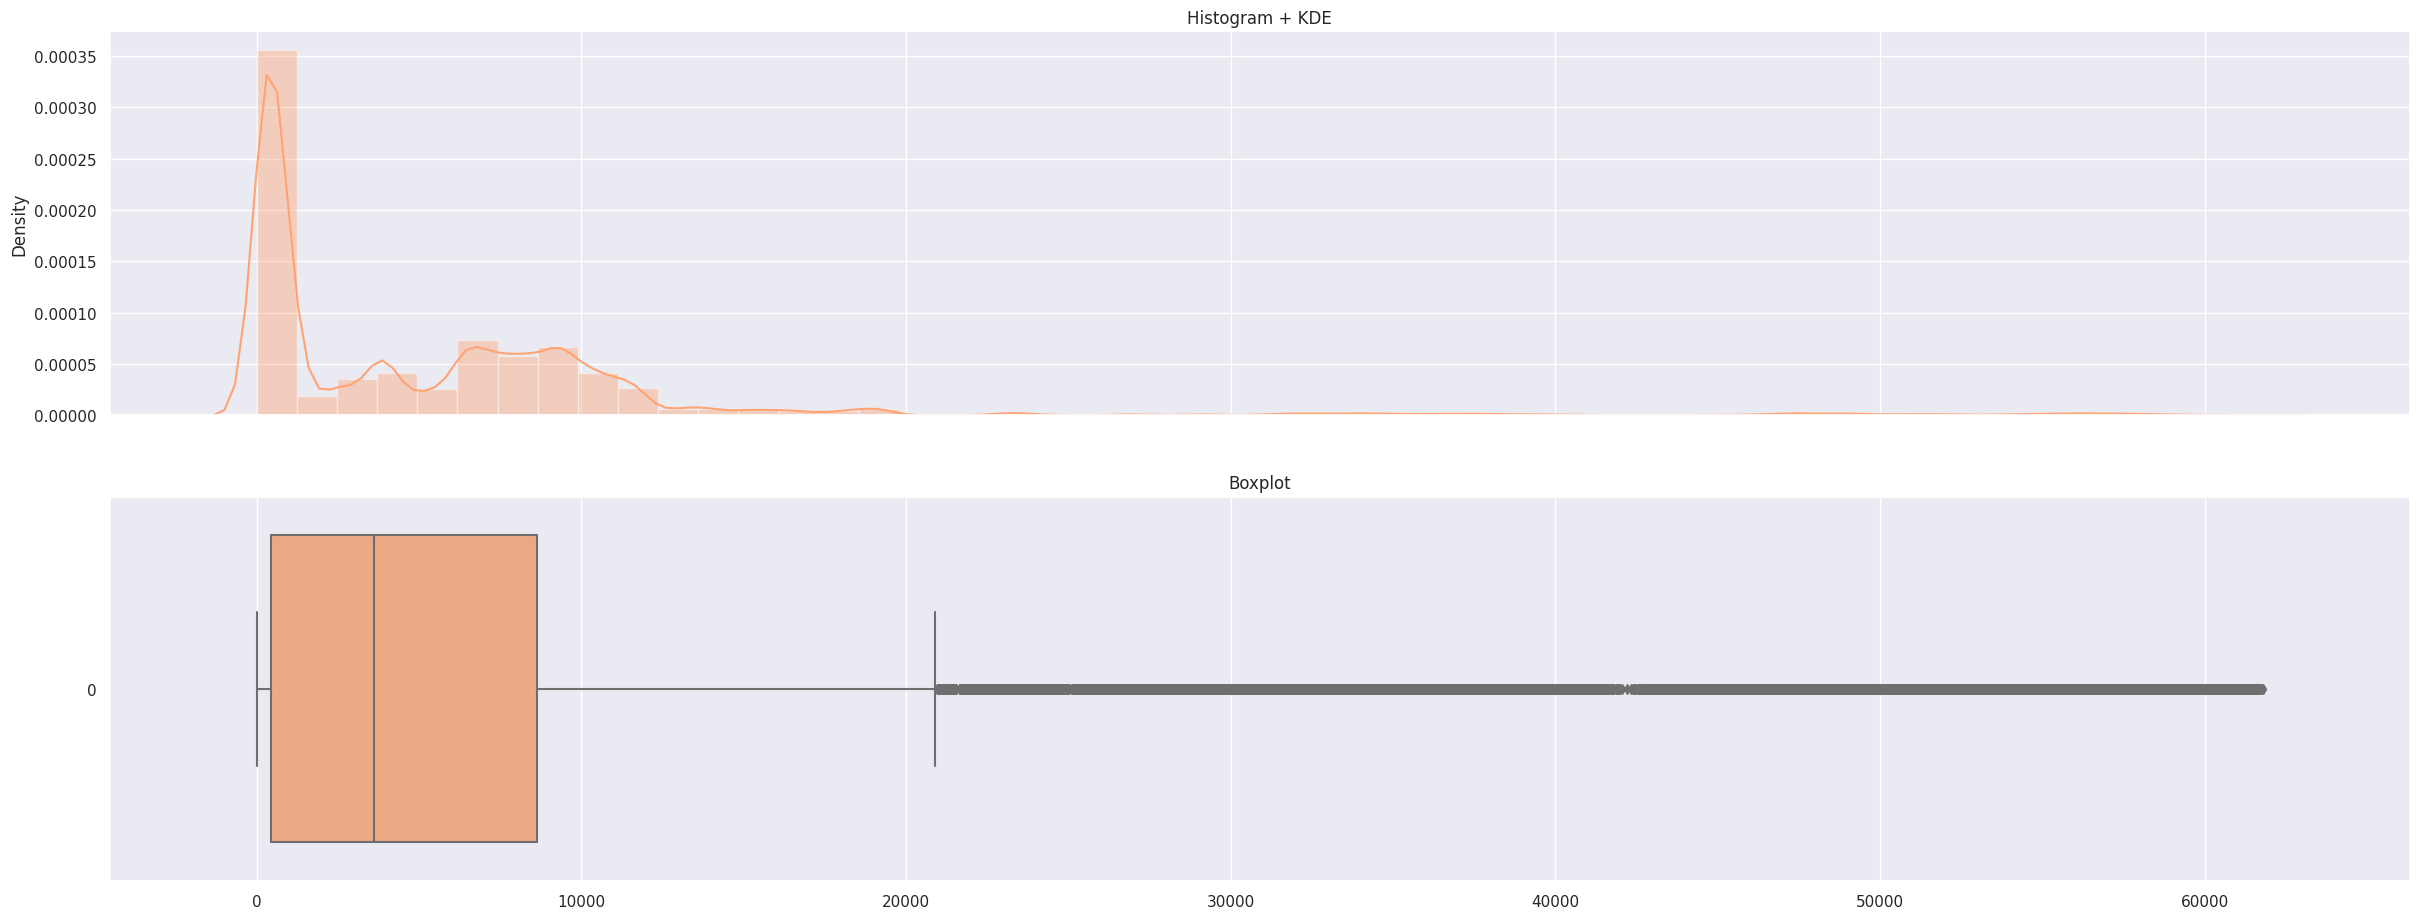

In [0]:
plts.DoublePlot(splitDFWithYear_pandas['Close'].tolist(),'Distribution of Opening price',custom_colors[3])

/root/.ipykernel/2159/command-651323311601319-48332007:40: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




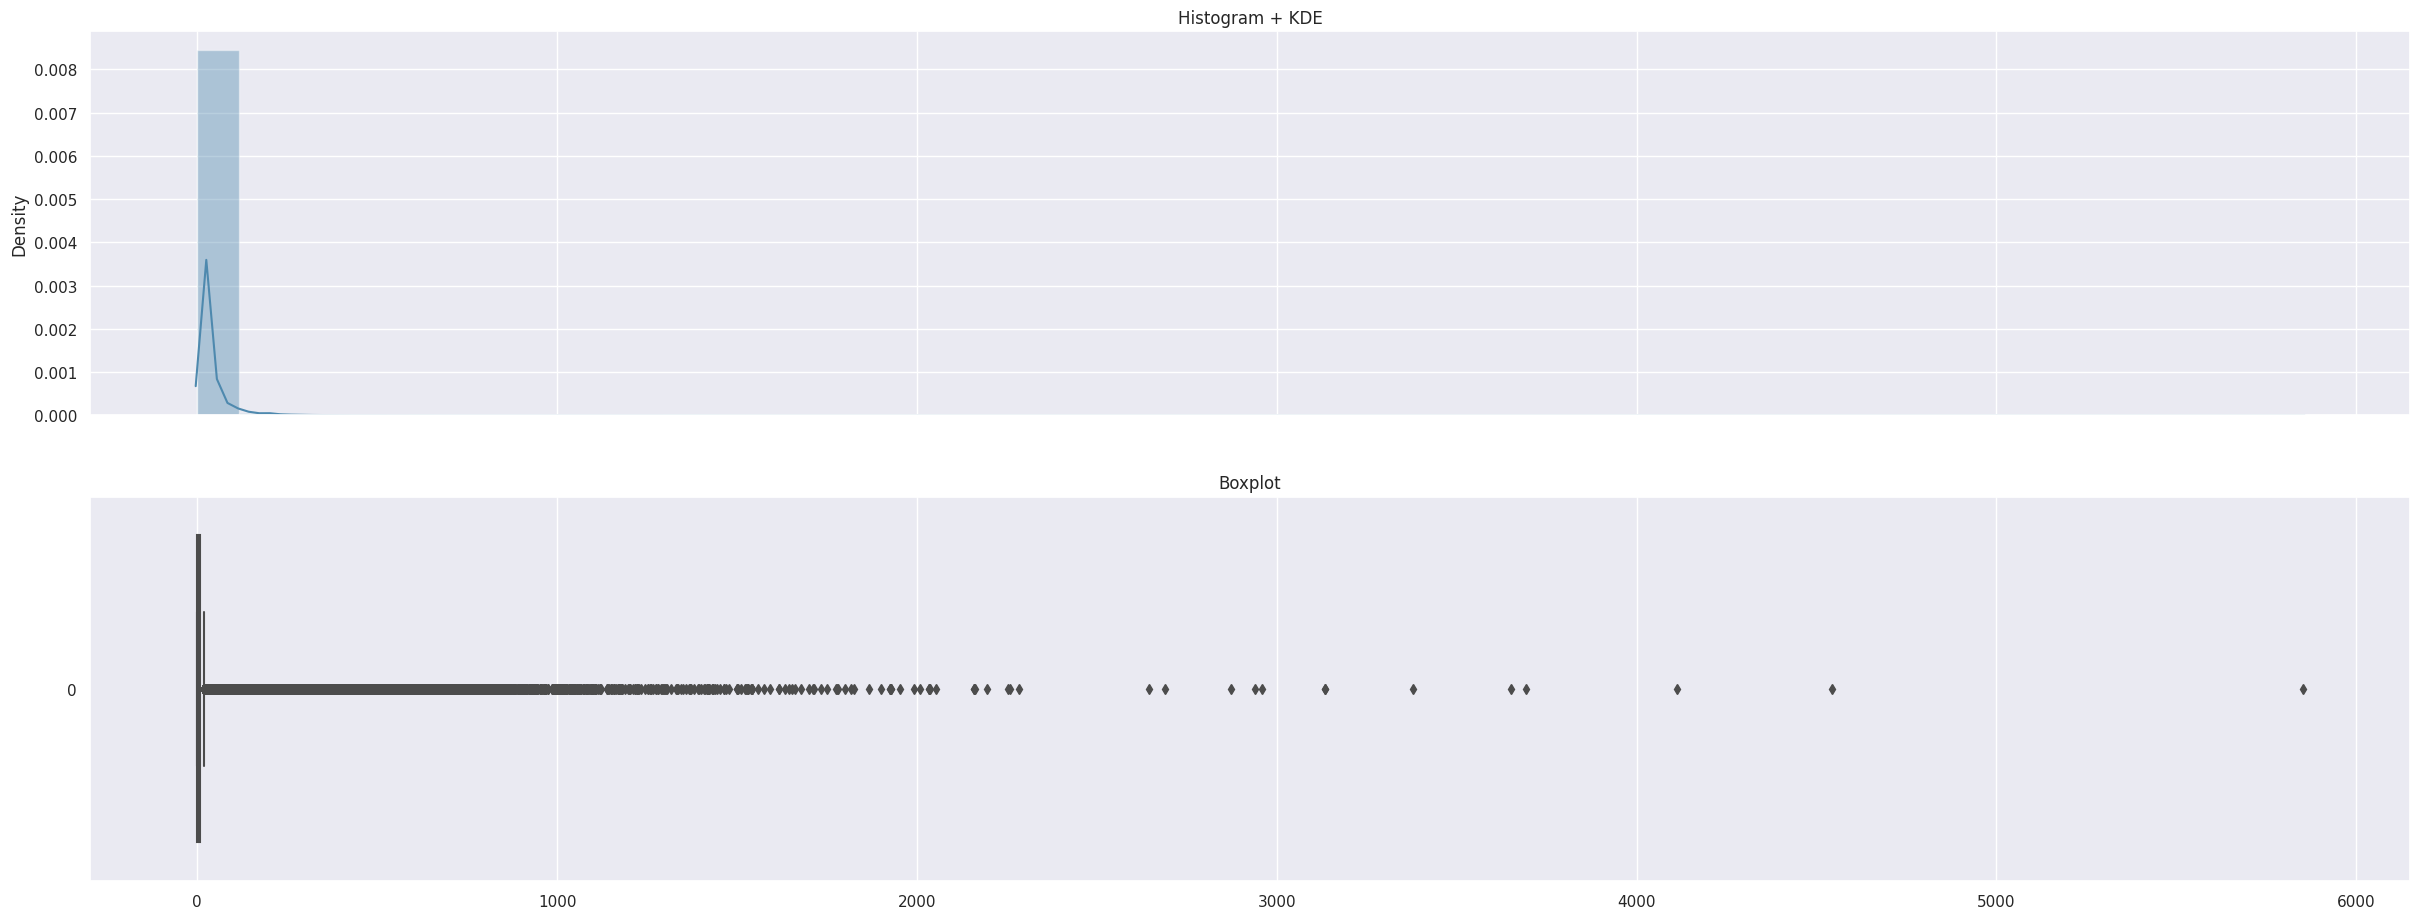

In [0]:
plts.DoublePlot(splitDFWithYear_pandas['VolBTC'],'Distribution of Volume in BTC ',custom_colors[0])

/root/.ipykernel/2159/command-651323311601319-48332007:40: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




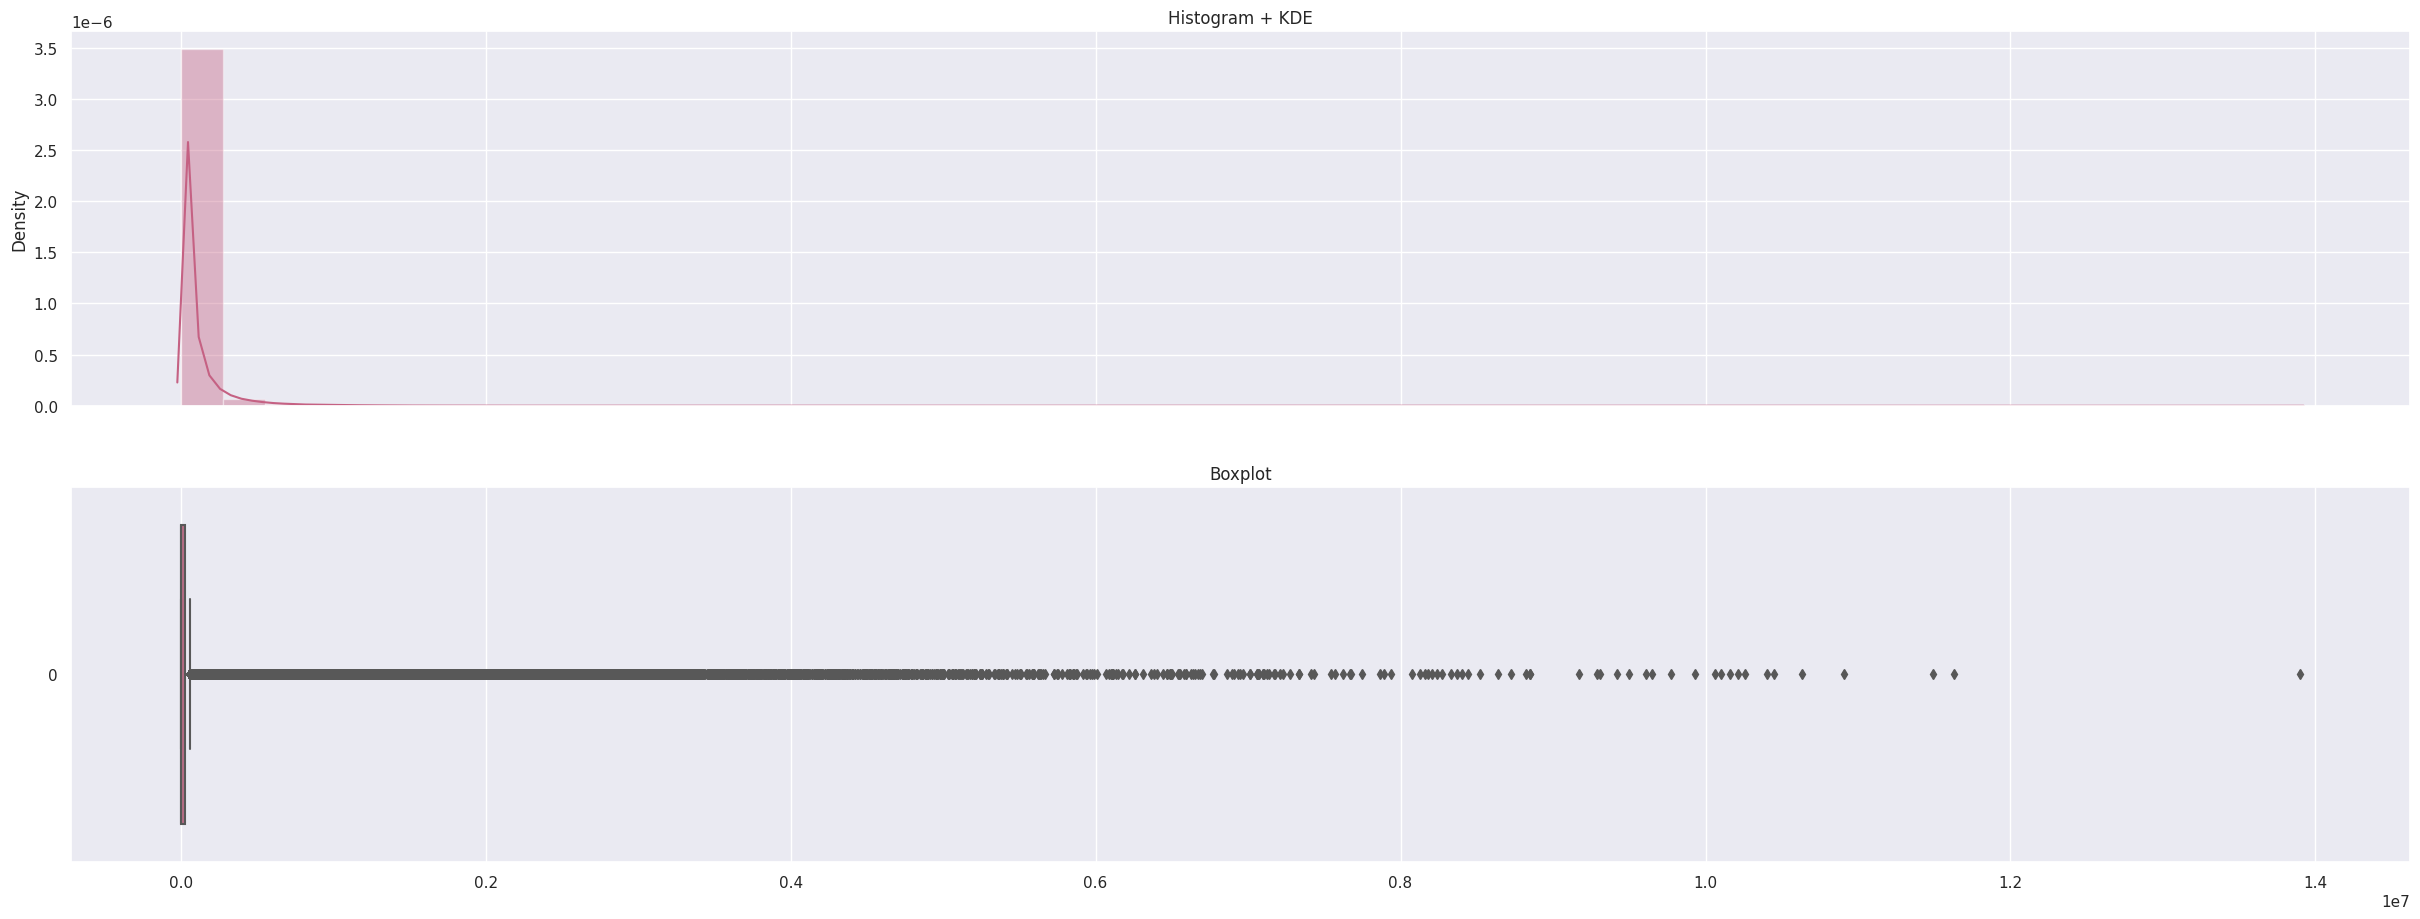

In [0]:
plts.DoublePlot(splitDFWithYear_pandas['VolCurrency'],'Distribution of Volume in BTC ',custom_colors[1])

/root/.ipykernel/2159/command-651323311601319-48332007:40: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




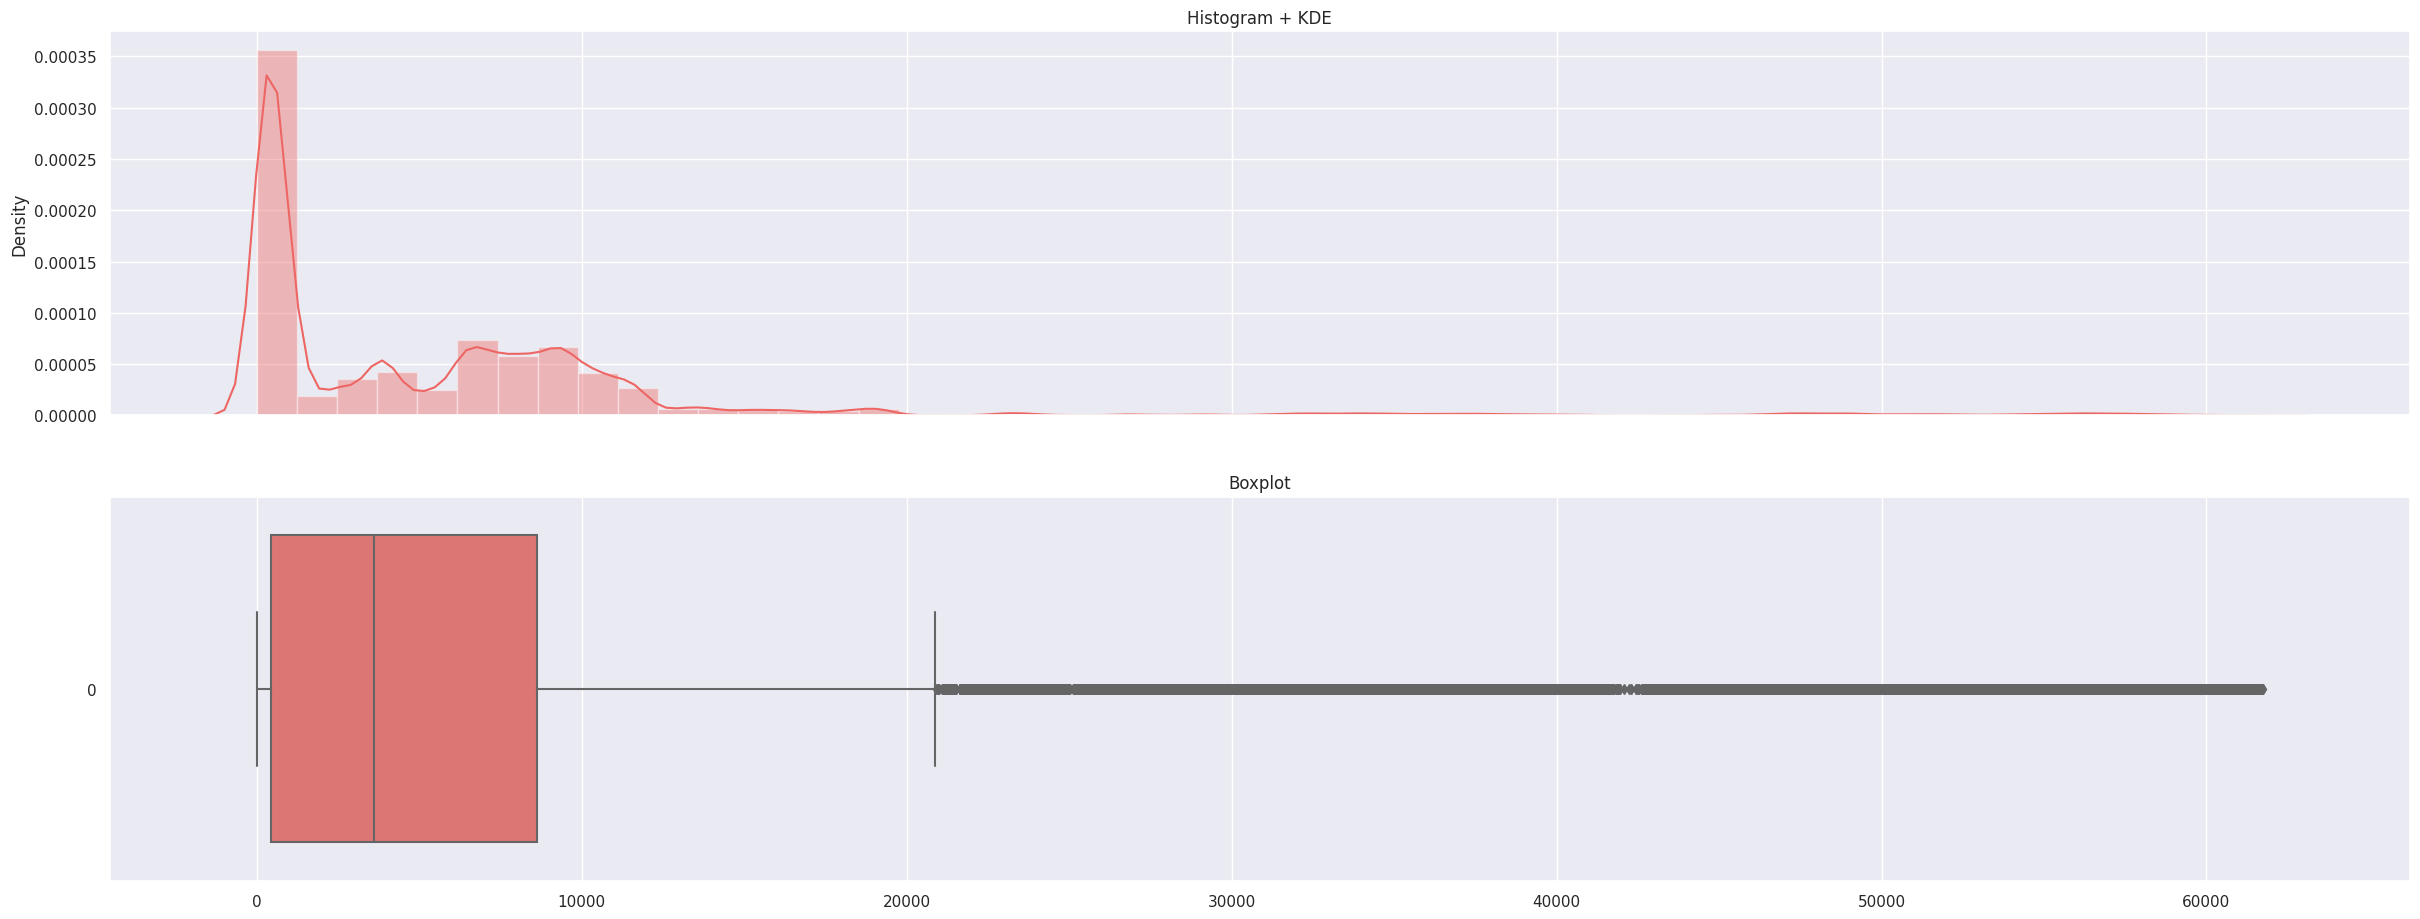

In [0]:


plts.DoublePlot(splitDFWithYear_pandas['Weighted_Price'],'Distribution of Weighted price',custom_colors[2])



## Correlation Graph

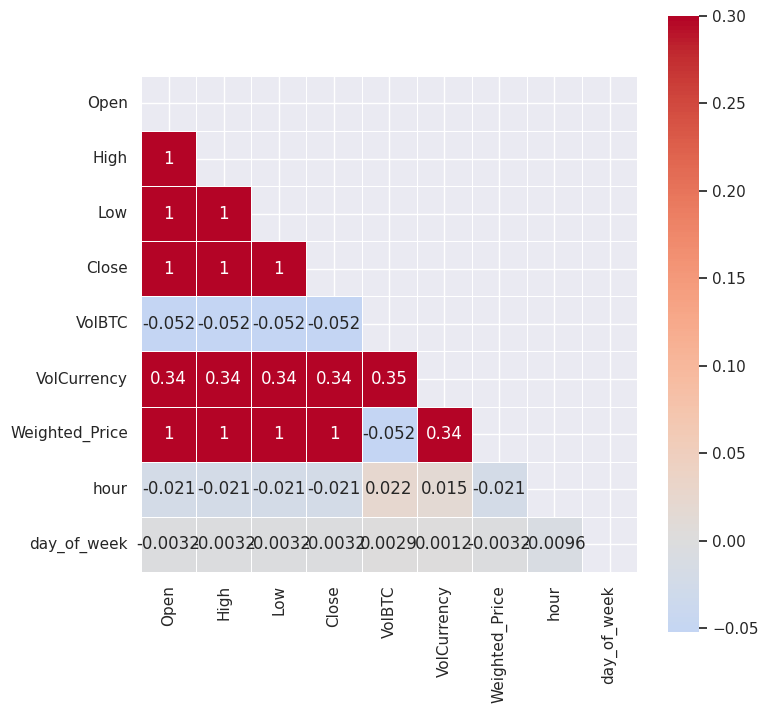

In [0]:
plts.Corr(splitDFWithYear_pandas)

## Kdeplots for Open,Close,High and Low

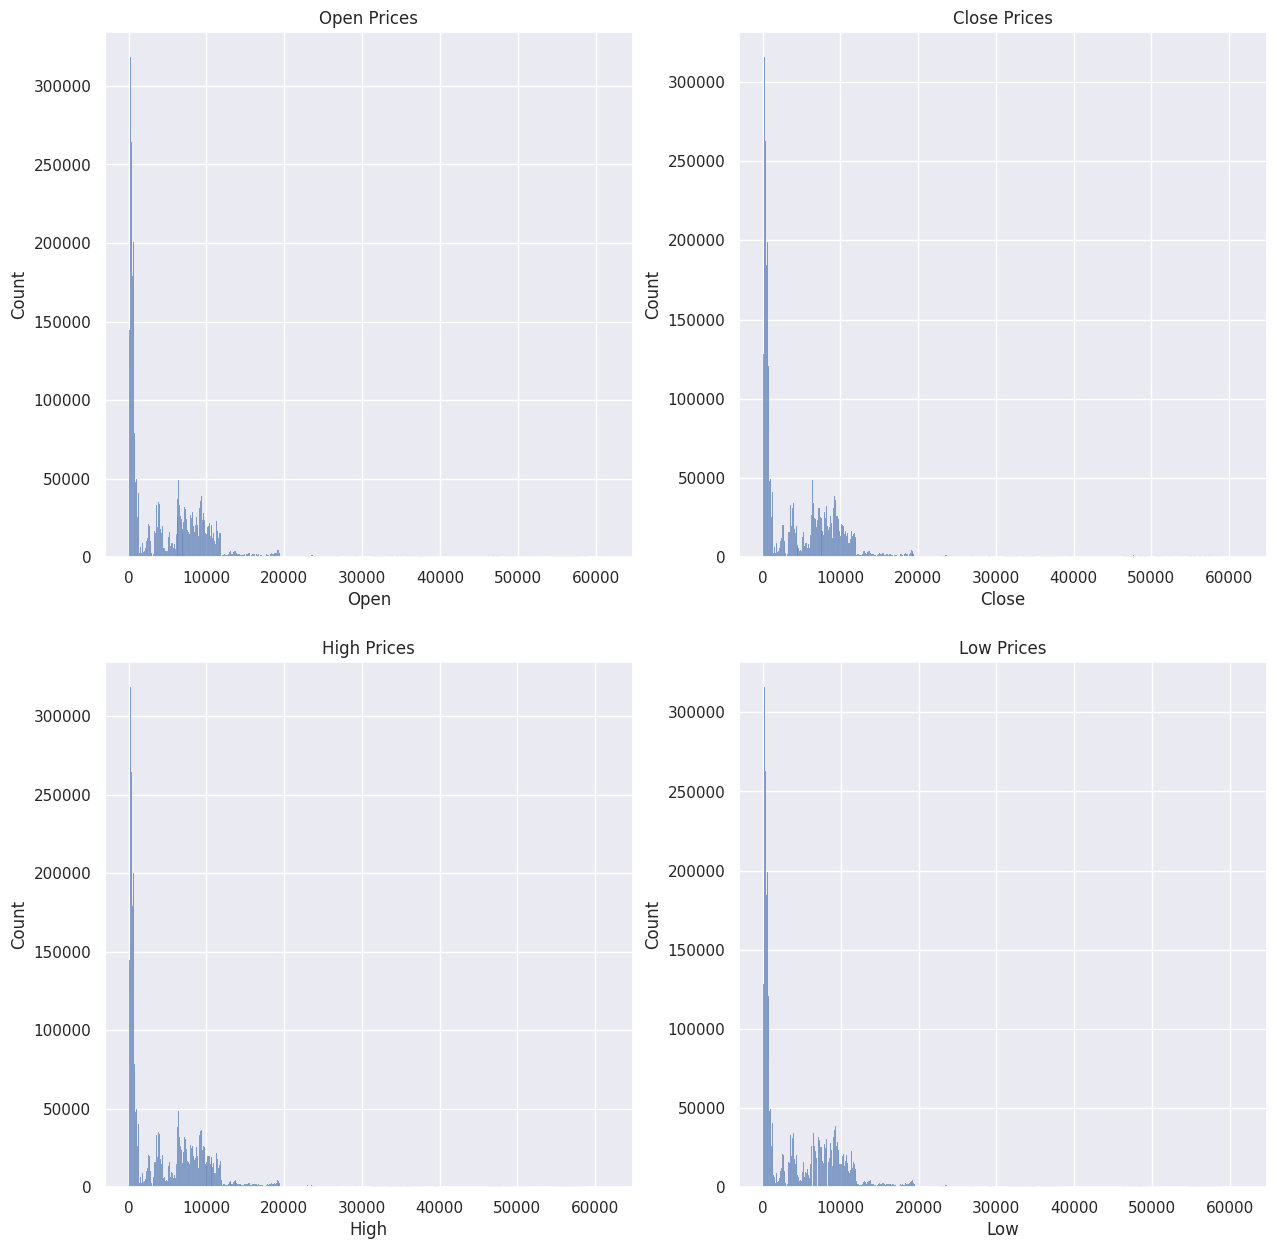

In [0]:
plts.MovingAvgs(splitDFWithYear_pandas)